# Complete Bend Process

This notebook contains the entire process for creating intersection-scale ridge measurements (ridge amplitude, width, and spacing) from the required input data (dem, manual ridge lines, packets, bend area, centerline). This process is the same process that has been split up across the other 3 notebooks, but without the context and explanation in markdown cells.


In [1]:
from pathlib import Path

import numpy as np
import geopandas as gpd
import rasterio
import rasterio.mask
import matplotlib.pyplot as plt

from parameters import (
    RASTER_WINDOW_SIZE, 
    SMOOTHING_WINDOW_SIZE,
    SMALL_FEATS_SIZE,
    VERTEX_SPACING,
    SHOOT_DISTANCE,
    SEARCH_DISTANCE,
    DEV_FROM_90
)

from scrollstats import create_ridge_area_raster_fs, LineSmoother, create_transects, calculate_ridge_metrics

In [2]:
# Bend ID
bend_id = "LBR_025"

# Raster Paths
dem_path = Path(f"example_data/input/{bend_id}_dem.tif")

# Vector Paths
bend_path = Path(f"example_data/input/{bend_id}_bend.geojson")
packet_path = Path(f"example_data/input/{bend_id}_packets.geojson")
centerline_path = Path(f"example_data/input/{bend_id}_cl.geojson")
manual_ridge_path = Path(f"example_data/input/{bend_id}_ridges_manual.geojson")

# Output Directory
output_dir = Path("example_data/output")


# Print constants from parameters.py
print(f"{RASTER_WINDOW_SIZE=}")
print(f"{SMOOTHING_WINDOW_SIZE=}")
print(f"{SMALL_FEATS_SIZE=}")
print(f"{VERTEX_SPACING=}")
print(f"{SHOOT_DISTANCE=}")
print(f"{SEARCH_DISTANCE=}")
print(f"{DEV_FROM_90=}")


RASTER_WINDOW_SIZE=45
SMOOTHING_WINDOW_SIZE=5
SMALL_FEATS_SIZE=500
VERTEX_SPACING=1
SHOOT_DISTANCE=300
SEARCH_DISTANCE=200
DEV_FROM_90=5


# Delineate Ridge Areas

Wrote ridge area raster to disk: example_data/output/LBR_025_dem_ridge_area_raster.tif
Wrote clipped DEM to disk: example_data/output/LBR_025_dem_clip.tif


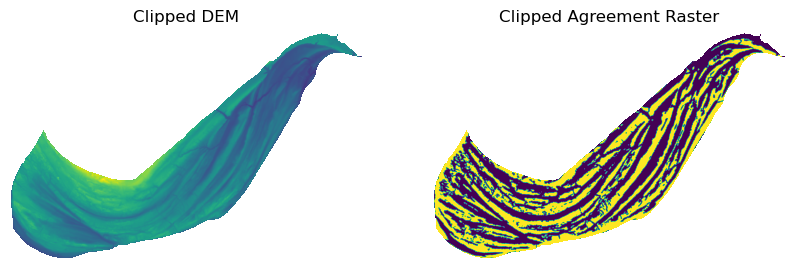

In [3]:
binary_path_out, dem_path_out = create_ridge_area_raster_fs(
    dem_path=dem_path,
    geometry_path=bend_path,
    out_dir=output_dir,
    no_data=np.nan, 
    window=RASTER_WINDOW_SIZE, 
    dx=1, 
    small_feats_size=SMOOTHING_WINDOW_SIZE
)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

dem_clip = rasterio.open(dem_path_out).read(1)
mapper = ax1.imshow(dem_clip)
ax1.set_axis_off()
ax1.set_title("Clipped DEM")

agr_clip = rasterio.open(binary_path_out).read(1)
mapper = ax2.imshow(agr_clip)
ax2.set_axis_off()
ax2.set_title("Clipped Agreement Raster");

# Create Vector Datasets

In [4]:
manual_ridges = gpd.read_file(manual_ridge_path)
cl = gpd.read_file(centerline_path)
packets = gpd.read_file(packet_path).set_index("packet_id")

In [5]:
# Smooth and densify the lines
ls = LineSmoother(manual_ridges, VERTEX_SPACING, SMOOTHING_WINDOW_SIZE)
smooth_ridges = ls.execute()

# Save smooth ridges to disk
output_dir = Path("example_data/output")
smooth_ridge_name = manual_ridge_path.with_stem(manual_ridge_path.stem + "_smoothed").name
smooth_ridge_path = output_dir / smooth_ridge_name

smooth_ridges.to_file(smooth_ridge_path, driver="GeoJSON", index=False)

# Plot manual and smoothed lines for comparison
m = manual_ridges.explore(color="black", style_kwds={"weight":5})
smooth_ridges.explore(color="red", m=m)

In [6]:
# define the distance between transects 
step = 100

# With a vertex spacing of ~1m, take every `step`th vertex along the centerline
starts = np.asarray(cl.geometry[0].xy).T[::step]

# Transect Parameters
shoot_distance = SHOOT_DISTANCE       # Distance that the N1 coordinate will shoot out from point P1; measured in linear unit of dataset
search_distance = SEARCH_DISTANCE     # Buffer radius used to search for an N2 coordinate on R2; measured in linear unit of dataset
dev_from_90 = DEV_FROM_90             # Max angular deviation from 90° allowed when searching for an N2 coordinate on R2; measured in degrees

transects = create_transects(cl, smooth_ridges, step, shoot_distance, search_distance, dev_from_90)

# Save transects to disk
transect_path = output_dir / f"{bend_id}_transects.geojson"
transects.to_file(transect_path, driver="GeoJSON", index=True)


--- Walking Transect t_000 ---
TRANSECT TERMINATED (iter=0): n1 shot failed to intersect any more ridges.

--- Walking Transect t_001 ---
TRANSECT TERMINATED (iter=0): n1 shot failed to intersect any more ridges.

--- Walking Transect t_002 ---
TRANSECT TERMINATED (iter=0): Failed to create n2 within a deviance of 5.0°

--- Walking Transect t_003 ---
TRANSECT TERMINATED (iter=0): Failed to create n2 within a deviance of 5.0°

--- Walking Transect t_004 ---
TRANSECT TERMINATED (iter=0): n1 shot failed to intersect any more ridges.

--- Walking Transect t_005 ---
TRANSECT TERMINATED (iter=0): Failed to create n2 within a deviance of 5.0°

--- Walking Transect t_006 ---
Iteration 00 result: [n1: POINT (1066806.880544728 3111441.3653525687), n2: POINT (1066803.737014806 3111451.251164231), p2: POINT (1066805.093997941 3111446.2700663134)]
Iteration 01 result: [n1: POINT (1066830.7635832166 3111454.2471496607), n2: POINT (1066828.4586901155 3111458.5861036708), p2: POINT (1066829.597776729

# Calculate Ridge Metrics

In [7]:
# Vector Data
ridges = gpd.read_file(smooth_ridge_path)
transects = gpd.read_file(transect_path)
packets = gpd.read_file(packet_path)
cl = gpd.read_file(centerline_path)

# Raster Data
bin_raster = rasterio.open(binary_path_out)
dem = rasterio.open(dem_path_out)

In [8]:
rich_transects, itx = calculate_ridge_metrics(transects, ridges, bin_raster, dem)
itx = itx.loc["LBR_025"]

# Add packets
itx_w_packets = itx.sjoin(packets.drop("bend_id", axis=1))
itx_w_packets = itx_w_packets.reset_index().set_index(["transect_id", "ridge_id", "packet_id"])
ridge_metrics_w_packets = itx_w_packets[["ridge_amp", "ridge_width", "pre_mig_dist", "geometry"]]
ridge_metrics_w_packets.columns = ridge_metrics_w_packets.columns.rename("metrics")

# Save to disk
itx_path = output_dir / f"{bend_id}_intersections.geojson"
ridge_metrics_w_packets.to_file(itx_path, driver="GeoJSON", index=True)

Started BDE
Started TDE for t_006
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_007
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_008
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_009
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_010
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_011
Started RDE
Started RDE
Started RDE
Started TDE for t_012
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_013
Started RDE
Started TDE for t_014
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_015
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_016
Started RDE
St

Text(0.5, 1.0, 'Ridge amplitude at each intersection')

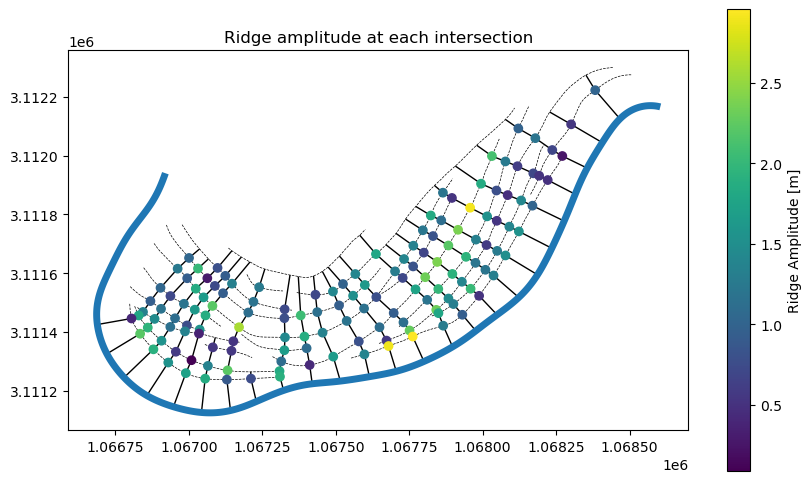

In [9]:
# Plot itx
fig, ax = plt.subplots(1,1, figsize=(10,6))
ridges.plot(ax=ax, color="k", ls="--", lw=0.5, zorder=0)
transects.plot(ax=ax, color="k", lw=1, zorder=1)
cl.plot(ax=ax, color="tab:blue", lw=5, zorder=2)

itx_w_packets.plot(column="ridge_amp", ax=ax, zorder=2, legend=True, 
                   legend_kwds={"label": "Ridge Amplitude [m]"})

ax.set_title("Ridge amplitude at each intersection")